import modules

In [1]:
from typing import Tuple
import numpy as np
import torch as t
from torch.distributions import uniform
from diffusion import diffuse
from diffusion_gumbel import diffuse_STE
from IPython.display import Image
from IPython import display
import matplotlib.pyplot as plt
from tqdm import tqdm

c:\Users\jsche\anaconda3\envs\torchenv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


define helper function to pre-process data

In [2]:
def chop_and_shuffle_data(sequence, shuffle=True):
    """
    Chop the training data into a set of state transitions and shuffle the resulting set.

    sequences (np.ndarray): matrix of shape (n_sequences, steps_per_seq, grid_height, grid_width)
    """
    steps_per_seq, _, grid_height, grid_width = sequence.shape
    # each transition consists of 2 states
    indexer = np.arange(2)[None, :] + np.arange(steps_per_seq - 1)[:, None]
    chopped_set = np.zeros(
        [(steps_per_seq - 1), 2, 2, grid_height, grid_width]
    )
    chopped_set = sequence.detach().numpy()[indexer]
    if shuffle:
        np.random.shuffle(chopped_set)
    return t.tensor(chopped_set)

define helper function to initialize the grid states

In [3]:
def init_grid(grid_size:int) -> t.Tensor:
    grid = t.zeros((2,512,512))
    grid[1,:,:] = 50
    grid[0,:,:] = 50 
    grid[0,251:261] = 90
    return grid

set hyperparameters

In [4]:
N = 100 
DA = 0.1
DB = 0.4
grid_size = 512
num_sequences = 30
sequences = []
steps_per_sequence = 10

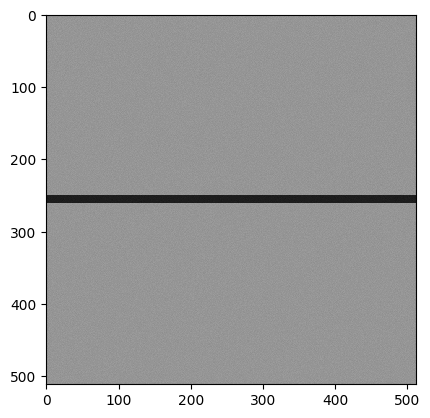

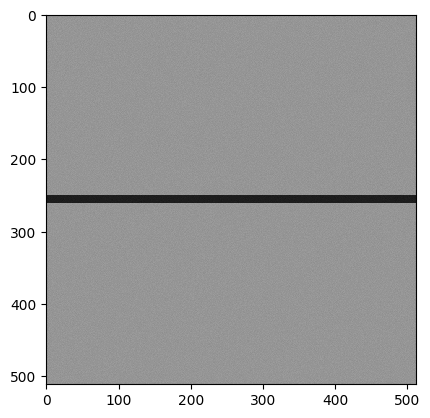

In [17]:
for i in tqdm(range(num_sequences)):
  grid = init_grid(grid_size)
  sequence = t.zeros((steps_per_sequence, 2, 512, 512))
  for i in range(steps_per_sequence):
    sequence[i] = grid
    grid = diffuse(grid, N, 0.5, 0.5)
  sequences.append(sequence)
for step in sequences[0]:
  display.clear_output(wait=True)
  plt.imshow(step[0].cpu(), cmap="Greys", interpolation="nearest", vmin=0, vmax=100)
  display.display(plt.gcf())

In [6]:
dataset = t.cat([chop_and_shuffle_data(seq, shuffle=False) for seq in sequences])
print(dataset.shape)

torch.Size([270, 2, 2, 512, 512])


tensor(2.8867)


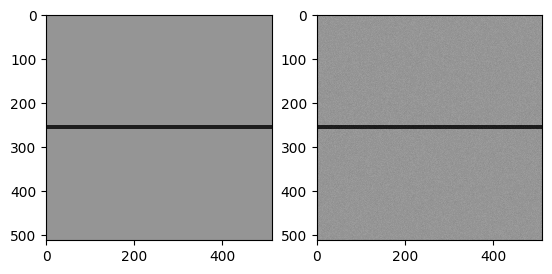

In [25]:
test_seq = sequences[0]

im1 = test_seq[0]
im2 = test_seq[-1]

norm = grid_size**2

print(t.sum((im1-im2)**2, dim=(-1,-2,-3))/norm)

fig, axs = plt.subplots(1,2)
axs[0].imshow(im1[0].cpu(), cmap="Greys", interpolation="nearest", vmin=0, vmax=100)
axs[1].imshow(im2[0].cpu(), cmap="Greys", interpolation="nearest", vmin=0, vmax=100)